# Synchronization of parametric with continuous AE recording

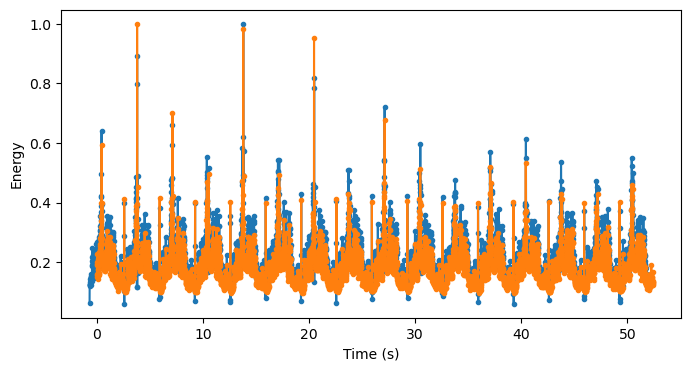

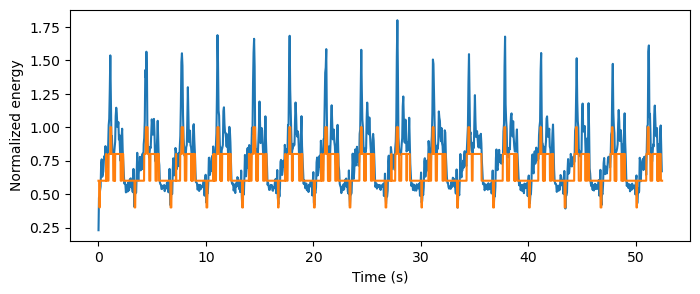

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from obspy import UTCDateTime

## Parametric data information

In [22]:
# Arguments for streams
folder = "data/Fatigue_INSA/"
files_name = "7075_APT_0.1_1"
files_ids = ["2"]
channel = "1"
files_suffix = "0-100"
mean_value = 500

# Arguments for parametric data
param_path = "Parametric_data/"+files_name

## Reading and preprocessing parametric data

### Mechanical noise and elastic recordings

In [23]:
# Param data reading --------------

if any(elem in "E" for elem in files_ids):
    datapath_E = param_path+"_E"+"_tdd.txt"
    
    # Data reading
    print("Loading parametric data in "+datapath_E)
    df = pd.read_csv(datapath_E,sep='\s+', header=0,skiprows=(0,1,2,3,4,5,6),encoding='latin-1')
    df = df.rename(columns={'SSSSSSSS.mmmuuun': 'time'})
    
    # Read first line containing datetime
    with open(datapath_E, 'r',encoding='latin-1') as f:
        TOA = f.readline()
    
    # Adding index with absolute time in date format
    timestamp = [str(UTCDateTime(TOA)+round(t-df.time[0],2)) for t in df.time[:]]
    df['timestamp'] = pd.to_datetime(timestamp) # Absolute time
    df = df.set_index(pd.DatetimeIndex(df['timestamp']))
    df.drop(columns=['ID'], inplace=True, axis=1)
    df.drop(columns=['timestamp'], inplace=True, axis=1)
    
    # Selecting the columns corresponding to the channel (and delete the unused)
    if channel == "2":
        df.drop(columns=['CH','RMS','ABS-ENERGY'], inplace=True, axis=1)
        df.rename(columns={'CH.1': 'CH', 'RMS.1': 'RMS','ABS-ENERGY.1':'ABS-ENERGY'}, inplace=True)
    else:
        df.drop(columns=['CH.1','RMS.1','ABS-ENERGY.1'], inplace=True, axis=1)       

    # --------------------------------------------------------------------------------------------
    ### Cycles count in dataframe
    
    # find zero-crossing indexes in loading serie (for load ratio R = -1)
    param_len = df.shape[0]
    zero_cross_id = [0]
    for i in range(param_len-1):
        if (df.PARA1.iloc[i]<mean_value) & (df.PARA1.iloc[i+1]>mean_value):
            zero_cross_id.append(i+1)
    
    # Create list of cycles count (with decimal) corresponding to dataframe shape and aligned with loading
    cycles = np.zeros(param_len)
    j = 0
    for i in range(1,len(zero_cross_id)-1):
        for j in range(zero_cross_id[i],zero_cross_id[i+1]):
            cycles[j] = i+(j-zero_cross_id[i])/(zero_cross_id[i+1]-zero_cross_id[i])
    # Last cycle values filling in case of not fully recorded cycle (with hypothesis of a cycle identical to previous one)
    for t in range(j+1,len(cycles)):
        cycles[t] = i+1+(t-zero_cross_id[i+1])/(zero_cross_id[i+1]-zero_cross_id[i])
    
    # Insertion in dataframe and compute normalized cycle position 
    df.CYCLES = cycles
    df['norm_cy'] = df.CYCLES-np.trunc(df.CYCLES)
    df = df.reindex(columns=['time', 'CYCLES','norm_cy','PARA1','PARA2','CH','RMS','ASL','ABS-ENERGY','CH.1','RMS.1','ABS-ENERGY.1'])
    df.drop(columns=['CH.1','RMS.1','ABS-ENERGY.1'], inplace=True, axis=1)       

    # -------------------------------------------------------------------------------------------
    
    
    df_E = df.copy()

    display(df_E.head())

if any(elem in "N" for elem in files_ids):
    datapath_N = param_path+"_N"+"_tdd.txt"

# Data reading
    print("Loading parametric data in "+datapath_N)
    df = pd.read_csv(datapath_N,sep='\s+', header=0,skiprows=(0,1,2,3,4,5,6),encoding='latin-1')
    df = df.rename(columns={'SSSSSSSS.mmmuuun': 'time'})
    
    # Read first line containing datetime
    with open(datapath_N, 'r',encoding='latin-1') as f:
        TOA = f.readline()
    
    # Adding index with absolute time in date format
    timestamp = [str(UTCDateTime(TOA)+round(t-df.time[0],2)) for t in df.time[:]]
    df['timestamp'] = pd.to_datetime(timestamp) # Absolute time
    df = df.set_index(pd.DatetimeIndex(df['timestamp']))
    df.drop(columns=['ID'], inplace=True, axis=1)
    df.drop(columns=['timestamp'], inplace=True, axis=1)
    
    # Selecting the columns corresponding to the channel (and delete the unused)
    if channel == "2":
        df.drop(columns=['CH','RMS','ABS-ENERGY'], inplace=True, axis=1)
        df.rename(columns={'CH.1': 'CH', 'RMS.1': 'RMS','ABS-ENERGY.1':'ABS-ENERGY'}, inplace=True)
    else:
        df.drop(columns=['CH.1','RMS.1','ABS-ENERGY.1'], inplace=True, axis=1)       

    df_N = df.copy()
    
    display(df_N.head())

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:67: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:67: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_13634/3253102188.py:8: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(datapath_E,sep='\s+', header=0,skiprows=(0,1,2,3,4,5,6),encoding='latin-1')
/tmp/ipykernel_13634/3253102188.py:67: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(datapath_N,sep='\s+', header=0,skiprows=(0,1,2,3,4,5,6),encoding='latin-1')


### Fatigue testing recordings

In [24]:
if any(elem not in ["E","N"] for elem in files_ids):    
    datapath_T = param_path+"_T"+"_tdd.txt"
    
    # Data reading
    print("Loading parametric data in "+datapath_T)
    df = pd.read_csv(datapath_T,sep='\s+', header=0,skiprows=(0,1,2,3,4,5,6),encoding='latin-1')
    df = df.rename(columns={'SSSSSSSS.mmmuuun': 'time'})
    
    # Read first line containing datetime
    with open(datapath_T, 'r',encoding='latin-1') as f:
        TOA = f.readline()
    
    # Adding index with absolute time in date format
    timestamp = [str(UTCDateTime(TOA)+round(t-df.time[0],2)) for t in df.time[:]]
    df['timestamp'] = pd.to_datetime(timestamp) # Absolute time
    df = df.set_index(pd.DatetimeIndex(df['timestamp']))
    df.drop(columns=['ID'], inplace=True, axis=1)
    df.drop(columns=['timestamp'], inplace=True, axis=1)
    
    # Selecting the columns corresponding to the channel (and delete the unused)
    if channel == "2":
        df.drop(columns=['CH','RMS','ABS-ENERGY'], inplace=True, axis=1)
        df.rename(columns={'CH.1': 'CH', 'RMS.1': 'RMS','ABS-ENERGY.1':'ABS-ENERGY'}, inplace=True)
    else:
        df.drop(columns=['CH.1','RMS.1','ABS-ENERGY.1'], inplace=True, axis=1)       

    # --------------------------------------------------------------------------------------------
    ### Cycles count in dataframe
    
    # find zero-crossing indexes in loading serie (for load ratio R = -1)
    param_len = df.shape[0]
    zero_cross_id = [0]
    for i in range(param_len-1):
        if (df.PARA1.iloc[i]<mean_value) & (df.PARA1.iloc[i+1]>mean_value):
            zero_cross_id.append(i+1)
    
    # Create list of cycles count (with decimal) corresponding to dataframe shape and aligned with loading
    cycles = np.zeros(param_len)
    for i in range(1,len(zero_cross_id)-1):
        for j in range(zero_cross_id[i],zero_cross_id[i+1]):
            cycles[j] = i+(j-zero_cross_id[i])/(zero_cross_id[i+1]-zero_cross_id[i])
    # Last cycle values filling in case of not fully recorded cycle (with hypothesis of a cycle identical to previous one)
    for t in range(j+1,len(cycles)):
        cycles[t] = i+1+(t-zero_cross_id[i+1])/(zero_cross_id[i+1]-zero_cross_id[i])
    
    # Insertion in dataframe and compute normalized cycle position 
    df.CYCLES = cycles
    df['norm_cy'] = df.CYCLES-np.trunc(df.CYCLES)
    df = df.reindex(columns=['time', 'CYCLES','norm_cy','PARA1','PARA2','CH','RMS','ASL','ABS-ENERGY','CH.1','RMS.1','ABS-ENERGY.1'])
    df.drop(columns=['CH.1','RMS.1','ABS-ENERGY.1'], inplace=True, axis=1)       

    # -------------------------------------------------------------------------------------------
    
    
    df_T = df.copy()
    
    display(df_T.head())

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_13634/759196857.py:6: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(datapath_T,sep='\s+', header=0,skiprows=(0,1,2,3,4,5,6),encoding='latin-1')


Loading parametric data in Parametric_data/7075_APT_0.1_1_T_tdd.txt


,time,CYCLES,norm_cy,PARA1,PARA2,CH,RMS,ASL,ABS-ENERGY
timestamp,,,,,,,,,
2024-12-02 16:36:01+00:00,0.049924,0.0,0.0,635.3760,-79.9561,1,0.0006,20,301.998
2024-12-02 16:36:01.050000+00:00,0.099923,0.0,0.0,693.6646,-78.4302,1,0.0006,20,284.682
2024-12-02 16:36:01.100000+00:00,0.149923,0.0,0.0,731.5063,-79.6509,1,0.0006,20,248.578
2024-12-02 16:36:01.150000+00:00,0.199924,0.0,0.0,780.6396,-77.8198,1,0.0006,19,250.242
2024-12-02 16:36:01.200000+00:00,0.249923,0.0,0.0,800.1709,-78.4302,1,0.0006,19,236.253


## Computing synchronisation for each stream and assembling parametric dataframes

Load stream 2


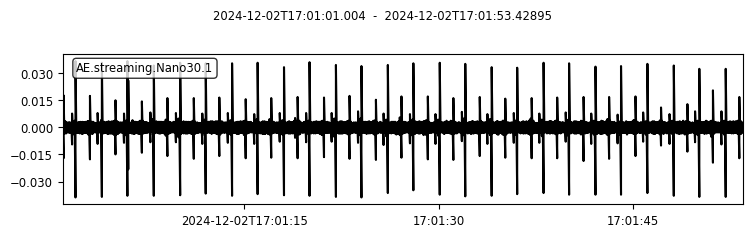

Stream start time : 2024-12-02T17:01:01.000000Z
Stream end time : 2024-12-02T17:01:53.420000Z
Parametric data relative start time : 1500.0499235
Parametric data relative end time : 1552.4499235


/tmp/ipykernel_13634/32450245.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Parametric data relative start time : "+str(param.time[0]))


Synchronisation lag (s) : 0.9


/tmp/ipykernel_13634/32450245.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(param.time-param.time[0],param_nrj,'.-')


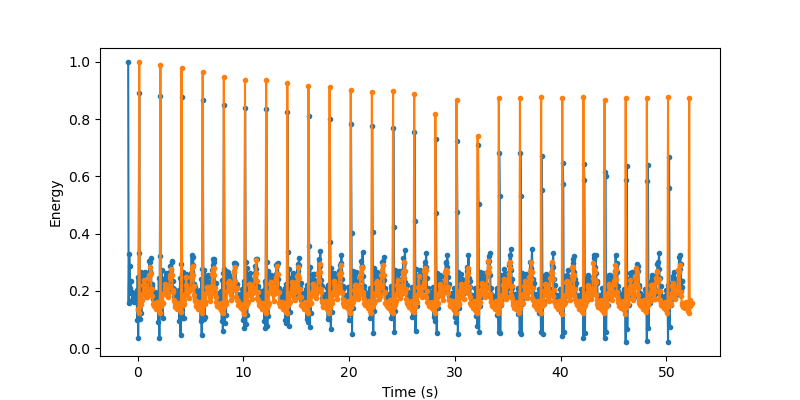

/tmp/ipykernel_13634/32450245.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  timestamp = [str(UTCDateTime(TOA)+round(t+dt[i]-df.time[0],2)) for t in df.time[:]]


,time,CYCLES,norm_cy,PARA1,PARA2,CH,RMS,ASL,ABS-ENERGY
timestamp,,,,,,,,,
2024-12-02 16:36:01.900000+00:00,0.049924,0.000,0.000,635.3760,-79.9561,1,0.0006,20,301.998
2024-12-02 16:36:01.950000+00:00,0.099923,0.000,0.000,693.6646,-78.4302,1,0.0006,20,284.682
2024-12-02 16:36:02+00:00,0.149923,0.000,0.000,731.5063,-79.6509,1,0.0006,20,248.578
2024-12-02 16:36:02.050000+00:00,0.199924,0.000,0.000,780.6396,-77.8198,1,0.0006,19,250.242
2024-12-02 16:36:02.100000+00:00,0.249923,0.000,0.000,800.1709,-78.4302,1,0.0006,19,236.253
...,...,...,...,...,...,...,...,...,...
2024-12-03 14:00:04.300000+00:00,77042.450124,38521.575,0.575,0.6104,-363.1592,1,0.0004,16,111.515
2024-12-03 14:00:04.350000+00:00,77042.500123,38521.600,0.600,-0.6104,-362.8540,1,0.0004,16,109.377
2024-12-03 14:00:04.400000+00:00,77042.550123,38521.625,0.625,-5.1880,-363.7695,1,0.0004,16,109.081


In [25]:
from scipy import signal
from math import ceil

param_data = pd.DataFrame()
dt = np.zeros(len(files_ids))    

for i,f in enumerate(files_ids):
    print("Load stream "+f)
    datapath = folder+"Stream_"+files_name+"_"+f+"_ch"+channel+"_"+files_suffix+".pkl"
    stream = pickle.load(open(datapath,'rb'))
    stream.plot()
    stream_signal = stream[0][:]
    time = stream[0].times()

    # Collecting DateTime in streams
    init_time = UTCDateTime(str(stream[0].stats.starttime)[:22])
    end_time = UTCDateTime(str(stream[0].stats.endtime)[:22])
    print("Stream start time : "+str(init_time))
    print("Stream end time : "+str(end_time))

    if f == "E":
        df = df_E
    elif f == "N":
        df = df_N
    else:
        df = df_T
    
    # Cutting a param dataframe around stream 
    param = df.copy()
    param = param[pd.to_datetime(str(init_time)):pd.to_datetime(str(end_time))]
    print("Parametric data relative start time : "+str(param.time[0]))
    print("Parametric data relative end time : "+str(param.time.iloc[-1]))

    # ===========================================================
    # timestamp_index = param.index.to_series()
    # display(timestamp_index)
    
    # Ensure the index is sorted
    # param = param.sort_index()

    # Find the nearest indices for init_time and end_time
    # nearest_init_index = param.index.asof(pd.to_datetime(str(init_time)))
    # nearest_end_index = param.index.asof(pd.to_datetime(str(end_time)))
    # nearest_init_index = timestamp_index.get_loc(pd.to_datetime(str(init_time)), method='nearest')
    # nearest_end_index = timestamp_index.get_loc(pd.to_datetime(str(end_time)), method='nearest')

    # print("Nearest index for init_time : " + str(nearest_init_index))
    # print("Nearest index for end_time : " + str(nearest_end_index))

    # Slice the param DataFrame using the nearest indices
    # param = param.iloc[nearest_init_index:nearest_end_index + 1]
    

    # Stream energy 
    stream_nrj = [x**2 for x in stream_signal]

    # Donwsampling to match param number of samples
    downsampling_f = ceil(len(stream_signal)/param.shape[0])
    stream_nrj_dec = signal.decimate(stream_nrj,downsampling_f)
    stream_nrj_dec /= np.max(stream_nrj_dec) # normalisation
    
    # Same for stream time (for plotting) 
    time_dec = signal.decimate(time,downsampling_f)
    coef_correction = pd.Series(time_dec).diff().mean()/(pd.Series(time).diff().mean()*downsampling_f)
    time_dec = time_dec/coef_correction
   
    # Param nrj normalisation
    param_nrj = param['ABS-ENERGY']/max(param['ABS-ENERGY'])

    # Compute cross-correlation 
    corr = signal.correlate(stream_nrj_dec,param_nrj)
    lags = signal.correlation_lags(len(stream_nrj_dec),len(param_nrj))
    
    # Find delay between series
    dx = lags[np.argmax(corr)]
    dt[i] = np.sign(dx)*time_dec[abs(dx)]
    dt[i] = round(dt[i], 2)  # Round to 2 decimal places
    print("Synchronisation lag (s) : "+str(dt[i])) 
    
    # Plot synchronised series
    %matplotlib widget   
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(time_dec-dt[i],stream_nrj_dec,'.-')
    ax.plot(param.time-param.time[0],param_nrj,'.-')
    plt.xlabel('Time (s)')
    plt.ylabel('Energy')
    plt.show()

    # Adding index with absolute time in date format
    timestamp = [str(UTCDateTime(TOA)+round(t+dt[i]-df.time[0],2)) for t in df.time[:]]
    df['timestamp'] = pd.to_datetime(timestamp) # Absolute time
    df = df.set_index(pd.DatetimeIndex(df['timestamp']))
    df.drop(columns=['timestamp'], inplace=True, axis=1) 
    display(df)

    # Cutting dataframe around stream (add 1 sec. to avoid loss of data)
    df= df[pd.to_datetime(str(init_time)):pd.to_datetime(str(end_time))]
        
    # df_nrj = df['ABS-ENERGY']
    # df_nrj /= max(df_nrj)
    
    # downsampling_f = 100000
    # stream_nrj_dec = signal.decimate(stream_nrj,downsampling_f)
    # stream_nrj_dec /= np.max(stream_nrj_dec) # normalisation
    
    # # Same for stream time (for plotting) 
    # time_dec2 = signal.decimate(time,downsampling_f)
    # coef_correction = pd.Series(time_dec2).diff().mean()/(pd.Series(time).diff().mean()*downsampling_f)
    # time_dec2 = time_dec2/coef_correction
    
    # fig, ax = plt.subplots(figsize=(8, 3))
    # ax.plot(time_dec2,stream_nrj_dec*1.8)
    # ax.plot(df.time-df.time.iloc[0],df_nrj,'-')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Normalized energy')
    # plt.show()
    # ===========================================================
    
    if not param_data.empty:
        df['time'] = df['time'] - df['time'].iloc[0] + param_data['time'].iloc[-1]

    param_data = pd.concat([param_data,df])

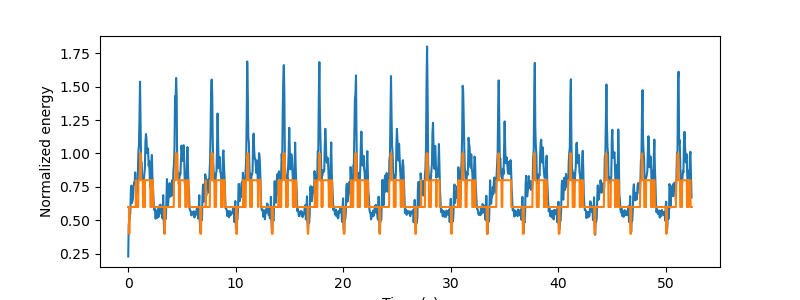

In [19]:
df_nrj = df['RMS']
df_nrj /= max(df_nrj)

downsampling_f = 100000
stream_nrj_dec = signal.decimate(stream_nrj,downsampling_f)
stream_nrj_dec /= np.max(stream_nrj_dec) # normalisation

# Same for stream time (for plotting) 
time_dec2 = signal.decimate(time,downsampling_f)
coef_correction = pd.Series(time_dec2).diff().mean()/(pd.Series(time).diff().mean()*downsampling_f)
time_dec2 = time_dec2/coef_correction

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(time_dec2,stream_nrj_dec*1.8)
ax.plot(df.time-df.time.iloc[0],df_nrj,'-')
plt.xlabel('Time (s)')
plt.ylabel('Normalized energy')
plt.show()

## Save parametric dataframe

In [26]:
folder = "Parametric_data/Param_data_assembly/"     # Folder and file (without extension)
datapath_save = folder+"Param_"+files_name+"_"+''.join(files_ids)+"_"+files_suffix+".pkl"

with open(datapath_save, "wb") as file:
    pickle.dump(param_data, file, protocol=pickle.HIGHEST_PROTOCOL)
print(datapath_save)

Parametric_data/Param_data_assembly/Param_7075_APT_0.1_1_2_0-100.pkl
